In [568]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from fastai.tabular.core import add_datepart
from sklearn.metrics import f1_score, classification_report
from bs4 import BeautifulSoup

### Import data

In [101]:
data = pd.read_json('data/data.json')

### Convert 'acct_type' to Target Labels based on presence of word "fraud"

In [102]:
data['Label'] = np.where(data['acct_type'].str.contains('fraud'), 1, 0)

In [103]:
data.head(1)

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,Label
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums/qq49/digusonline/?action=view&amp;current=supersunday.jpg"" target=""_blank""><img src=""http://i432.photobucket.com/albums/qq49/digusonline/supersunday.jpg"" border=""0"" alt=""Photobucket"" /></a></p>\r\n<p> </p>\r\n<p style=""text-align: center;""><font size=""3""><strong>Party Starz Entertaintment &amp; Diverse International Group Presents...<br /></strong></font><br /><font face=""tahoma,arial,helvetica,sans-serif"" size=""4""><strong>The Official ""99 Hour No Sleep"" Super Bowl </strong></font></p>\r\n<p style=""text-align: center;""><font face=""tahoma,arial...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.0,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEND GRAND FINALE",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availability': 1, 'quantity_total': 800, 'quantity_sold': 0}, {'event_id': 527017, 'cost': 50.0, 'availability': 1, 'quantity_total': 100, 'quantity_sold': 0}, {'event_id': 527017, 'cost': 550.0, 'availability': 1, 'quantity_total': 20, 'quantity_sold': 0}]",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL,1


### Define replace function for handling missing (non-NaN) data

In [104]:
def replace(row):
    if len(row) < 1:
        return "UNK"
    else: return row

In [105]:
data['payout_type'] = data['payout_type'].apply(replace)
data['country'].fillna('UNK', inplace=True)
data['country'] = data['country'].apply(replace)
data['venue_state'].fillna('UNK', inplace=True)
data['venue_state'] = data['venue_state'].apply(replace)

### Time Series conversions

In [279]:
data['user_created'] = pd.to_datetime(data['user_created'], unit='s')
data['approx_payout_date'] = pd.to_datetime(data['approx_payout_date'], unit = 's')
data['event_created'] = pd.to_datetime(data['event_created'], unit='s')
data['event_end']= pd.to_datetime(data['event_end'], unit='s')
data['event_published'] = pd.to_datetime(data['event_published'], unit='s')
data['event_start'] = pd.to_datetime(data['event_start'], unit='s')
data['time_diff'] = data['event_end'] - data['event_start']
data['time_diff_days'] = data['time_diff'].dt.days
data['time_diff_seconds'] = data['time_diff'].dt.total_seconds()

In [107]:
data['year'] = data['approx_payout_date'].dt.year
data['month'] = data['approx_payout_date'].dt.month
data['day'] = data['approx_payout_date'].dt.day
data['hour'] = data['approx_payout_date'].dt.hour
data['minute'] = data['approx_payout_date'].dt.minute
data['dayofyear'] = data['approx_payout_date'].dt.dayofyear
data['weekofyear'] = data['approx_payout_date'].dt.weekofyear
data['week'] = data['approx_payout_date'].dt.week
data['dayofweek'] = data['approx_payout_date'].dt.dayofweek
data['quarter'] = data['approx_payout_date'].dt.quarter
data['is_month_start'] = data['approx_payout_date'].dt.is_month_start
data['is_month_end'] = data['approx_payout_date'].dt.is_month_end
data['is_quarter_start'] = data['approx_payout_date'].dt.is_quarter_start
data['is_quarter_end'] = data['approx_payout_date'].dt.is_quarter_end

<ipython-input-107-5489717b1398>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data['approx_payout_date'].dt.weekofyear
<ipython-input-107-5489717b1398>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week'] = data['approx_payout_date'].dt.week


### Separate datasets into fraud and non-fraud for some visual EDA

In [282]:
fraud = data[data['Label'] == 1]
nonfraud = data[data['Label'] == 0]

### Define columns for histogram plots

In [11]:
cols = [
    'acct_type', 'approx_payout_date', 'body_length', 'channels', 'country',
       'currency', 'delivery_method', 'email_domain',
       'event_created', 'event_end', 'event_published', 'event_start',
       'fb_published', 'gts', 'has_analytics', 'has_header', 'has_logo',
       'listed', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_facebook', 'org_twitter',
       'payee_name', 'payout_type', 'sale_duration',
       'sale_duration2', 'show_map', 'user_age',
       'user_created', 'user_type',  'venue_country', 'venue_state'
]

In [64]:
def hist_plots(fraud_df, nonfraud_df, column, bins=30):
    '''
    Plots a comparison histogram on same plot between fraud and nonfraudulent events
    '''
    
    plt.hist(nonfraud_df[column], label="Class #0", alpha=0.5, edgecolor='black', lw=1.5, color='blue', bins=bins)
    plt.hist(fraud_df[column], label="Class #1", alpha=0.5, edgecolor='black', linewidth=1.5, color='r', bins=bins)
    plt.title(column, fontsize=34)
    plt.legend(fontsize='xx-large')
    return plt.show()

In [14]:
# for col in cols:
#     try:
#         hist_plots(fraud, nonfraud, col)
#     except TypeError:
#         pass

#### **** Look at org name, previous payouts, any text based columns, ticket types, lat, long, venue address and name, separately ****

### Convert ticket_type column into Dataframe for analysis

In [11]:
pd.DataFrame(fraud.ticket_types[0])

,event_id,cost,availability,quantity_total,quantity_sold
0,527017,25.0,1,800,0
1,527017,50.0,1,100,0
2,527017,550.0,1,20,0


### Fraud conversion + analytsis

In [154]:
frame_list = []
for x in fraud.ticket_types.values:
    frame_list.append(pd.DataFrame(x))

fraud_ticket_types = pd.concat(frame_list)

frame_list = []
for x in nonfraud.ticket_types.values:
    frame_list.append(pd.DataFrame(x))

nonfraud_ticket_types = pd.concat(frame_list)

fraud_ticket_types.reset_index(drop=True, inplace=True)
nonfraud_ticket_types.reset_index(drop=True, inplace=True)

fraud_ticket_types.iloc[:, 1:].describe()
nonfraud_ticket_types.iloc[:, 1:].describe()

### Time Series Analysis

In [15]:
time_cols = ['year', 'month', 'day', 'hour', 'minute', 'dayofyear',
       'weekofyear', 'week', 'dayofweek', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end']

In [16]:
# for col in time_cols:
#     try:
#         hist_plots(fraud, nonfraud, col)
#     except TypeError:
#         pass

In [191]:
features = ['body_length', 'channels', 'country',
       'currency', 'delivery_method', 'email_domain',
       'fb_published', 'has_header', 'has_logo', 'name_length',
       'object_id', 'org_facebook', 'org_twitter',
       'show_map', 'user_age',
       'user_created', 'venue_country',
       'venue_latitude', 'venue_longitude', 'venue_state',
       'Label', 'year', 'month', 'day', 'hour', 'minute', 'dayofyear',
       'weekofyear', 'week', 'dayofweek', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'time_diff',
       'time_diff_seconds', 'previous_payout0']

In [36]:
def compare(frauddf, nonfrauddf, col):
    print(f'Fraud: \n{frauddf[col].value_counts()/len(frauddf)*100} \n\n\nNonFraud: \n{nonfrauddf[col].value_counts()/len(nonfrauddf) * 100}\n\n')

In [134]:
compare(fraud, nonfraud, 'user_type')

Fraud: 
1    71.771075
3    22.815159
4     5.104408
5     0.232019
2     0.077340
Name: user_type, dtype: float64 


NonFraud: 
3      55.389451
4      22.623428
1      21.542472
5       0.429316
103     0.015333
Name: user_type, dtype: float64




In [116]:
len(nonfraud[nonfraud['num_order'] == 0])/len(nonfraud), len(nonfraud[nonfraud['num_order'] == 0]), len(nonfraud)

(0.002836553204538485, 37, 13044)

In [117]:
len(fraud[fraud['num_order'] == 0])/len(fraud), len(fraud[fraud['num_order'] == 0]), len(fraud)

(0.24748646558391338, 320, 1293)

### Text columns:
- description
- name
- org_description
- org_name
- venue address
- venue_name

### Leaky columns
- num_order
- num_payouts
- gts

In [289]:
columns_removed = set(data.columns).difference(features)
columns_removed

{'acct_type',
 'approx_payout_date',
 'description',
 'event_created',
 'event_end',
 'event_published',
 'event_start',
 'gts',
 'has_analytics',
 'listed',
 'name',
 'num_order',
 'num_payouts',
 'org_desc',
 'org_name',
 'payee_name',
 'payout_type',
 'previous_payouts',
 'sale_duration',
 'sale_duration2',
 'ticket_types',
 'time_diff_days',
 'user_type',
 'venue_address',
 'venue_name'}

### Feature engineering List:
- num order
- gts

In [194]:
model_cols.drop(['org_name', 'ticket_types', 'venue_address', 'venue_name'], axis=1, inplace=True)

In [180]:
model_cols['previous_payout0'] = np.where(truth_col, 1, 0)

In [208]:
event_cols = model_cols.columns[model_cols.columns.str.contains('event')]

In [209]:
model_cols.drop(event_cols, axis=1, inplace=True)

In [218]:
model_cols.has_header.fillna('UNK', inplace=True)

In [219]:
model_cols.has_header.value_counts()

0.0    7124
UNK    5409
1.0    1804
Name: has_header, dtype: int64

In [220]:
fraud = model_cols[model_cols['Label'] == 1]
nonfraud = model_cols[model_cols['Label'] == 0]

In [223]:
fraud_header = compare(fraud, nonfraud, 'has_header')

Fraud: 
UNK    59.860789
0.0    37.354988
1.0     2.784223
Name: has_header, dtype: float64 


NonFraud: 
0.0    50.912297
UNK    35.533579
1.0    13.554125
Name: has_header, dtype: float64




In [233]:
dummy_cols = pd.get_dummies(model_cols, columns=['has_header'], dummy_na=True)

In [235]:
dummy_cols.drop(['country', 'currency', 'previous_payouts'], axis=1, inplace=True)

In [247]:
dummy_cols.drop('time_diff', axis=1, inplace=True)

In [249]:
dummy_cols.head()

,body_length,channels,delivery_method,email_domain,fb_published,has_logo,name_length,object_id,org_facebook,org_twitter,show_map,user_age,user_created,user_type,venue_country,venue_latitude,venue_longitude,venue_state,Label,year,month,day,hour,minute,dayofyear,weekofyear,week,dayofweek,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,time_diff_seconds,previous_payout0,has_header_0.0,has_header_1.0,has_header_nan
0,3852,5,0.0,gmail.com,0,0,60,527017,0.0,0.0,1,36,1259613950,1,US,25.777471,-80.133433,FL,1,2010,2,13,12,0,44,6,6,5,1,False,False,False,False,36000.0,1,0,1,0
1,3499,0,1.0,ruf.org,0,1,27,786878,0.0,12.0,0,149,1280942776,3,US,32.776566,-79.930922,SC,0,2011,2,3,8,0,34,5,5,3,1,False,False,False,False,32400.0,0,1,0,0
2,2601,8,1.0,pvsd.k12.ca.us,0,0,28,787337,0.0,0.0,0,214,1272559388,3,US,33.944201,-118.080419,CA,0,2011,1,28,0,0,28,4,4,4,1,False,False,False,False,27000.0,0,0,0,1
3,12347,6,1.0,irishtabletennis.com,0,1,21,885645,0.0,0.0,0,889,1283870102,3,None,NaN,NaN,UNK,0,2014,1,6,0,0,6,2,2,0,1,False,False,False,False,27831600.0,0,1,0,0
4,2417,11,0.0,artsandbusinesscouncil.org,1,0,66,1114349,0.0,0.0,0,35,1288984065,3,US,42.353848,-71.044276,MA,0,2011,2,17,0,0,48,7,7,3,1,False,False,False,False,28800.0,0,1,0,0


In [256]:
dummy_cols['yahoo'] = np.where(model_cols['email_domain'].str.contains('yahoo'), 1, 0)

In [272]:
dummy_cols['is_fr'] = np.where(model_cols['email_domain'].str.endswith('fr'), 1, 0)

In [275]:
dummy_cols['is_org'] = np.where(model_cols['email_domain'].str.endswith('.org'), 1, 0)

In [281]:
data['user_created'].dt.year

0        2009
1        2010
2        2010
3        2010
4        2010
         ... 
14332    2013
14333    2009
14334    2012
14335    2010
14336    2013
Name: user_created, Length: 14337, dtype: int64

In [290]:
dummy_cols.drop(['email_domain', 'object_id', 'user_created', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_state'], axis=1, inplace=True)

In [304]:
dummy_cols.drop(['year'], axis=1, inplace=True)

In [332]:
# filled_nas = dummy_cols
# filled_nas.org_facebook.fillna(-1, inplace=True)
# filled_nas.org_twitter.fillna(-1, inplace=True)
filled_nas.delivery_method.value_counts()

0.0    8520
1.0    5554
3.0     247
Name: delivery_method, dtype: int64

In [335]:
filled_nas = pd.get_dummies(filled_nas, columns=['delivery_method'], dummy_na=True)

# Baseline Model (RF)

In [402]:
rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1, verbose=1)

In [367]:
X = filled_nas.drop('Label', axis=1).values
y = filled_nas['Label'].values

In [403]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [404]:
rf.fit(xtrain, ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    1.8s finished


RandomForestClassifier(n_estimators=1500, n_jobs=-1, verbose=1)

In [405]:
np.mean(cross_val_score(rf, xtrain, ytrain, scoring='f1', cv=10, verbose=1, n_jobs=4))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   11.7s finished


0.8919325591485426

# Time removed Model 

In [437]:
rf_time = RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)

In [425]:
time_columns = filled_nas.iloc[:,11:25].columns

In [426]:
final_cols = filled_nas.columns[~filled_nas.columns.isin(time_columns)]

In [427]:
no_time = filled_nas.loc[:, final_cols]

In [428]:
timeX = no_time.drop('Label', axis=1).values
timey = no_time['Label'].values

In [438]:
timextrain, timextest, timeytrain, timeytest = train_test_split(timeX, timey, stratify=timey, test_size=.15)

In [439]:
rf_time.fit(timextrain, timeytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)

In [440]:
np.mean(cross_val_score(rf_time, timextrain, timeytrain, scoring='f1', cv=10, verbose=1, n_jobs=8))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.4s finished


0.8947471296019494

# Cost data added Model

In [549]:
rf_neg = RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)

In [550]:
negX = neg_value_cols.drop('Label', axis=1).values
negy = neg_value_cols['Label'].values

In [554]:
negxtrain, negxtest, negytrain, negytest = train_test_split(negX, negy, stratify=negy, test_size=.15)

In [552]:
rf_neg.fit(negxtrain, negytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, verbose=1)

In [555]:
np.mean(cross_val_score(rf_neg, negxtrain, negytrain, scoring='f1', cv=10, verbose=1, n_jobs=8))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.0s finished


0.9008390816621171

# Let the Hyperparameter tuning begin!!!

In [557]:
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [563]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = rf_neg, param_distributions = random_grid, scoring='f1', n_iter = 150, cv = 5, verbose=2, random_state=42, n_jobs = 8)
# Fit the random search model
search = rf_random.fit(negxtrain, negytrain)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   53.8s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


In [569]:
best_model = search.best_estimator_

In [571]:
predictions = best_model.predict(negxtest)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


In [574]:
f1_score(negytest, predictions)

0.9315789473684211

In [580]:
print(classification_report(negytest, predictions, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       0.99      1.00      0.99      1957
       Fraud       0.95      0.91      0.93       194

    accuracy                           0.99      2151
   macro avg       0.97      0.95      0.96      2151
weighted avg       0.99      0.99      0.99      2151



### Results indicate minimal gain for increasing n_estimators beyond 500

In [435]:
scores = []
for value in np.arange(500, 1501, 500):
    rf_model = RandomForestClassifier(n_estimators=value, n_jobs=-1, verbose=1)
    score = np.mean(cross_val_score(rf_time, timextrain, timeytrain, scoring='f1', cv=10, verbose=1, n_jobs=8))
    scores.append(score)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.5s finished


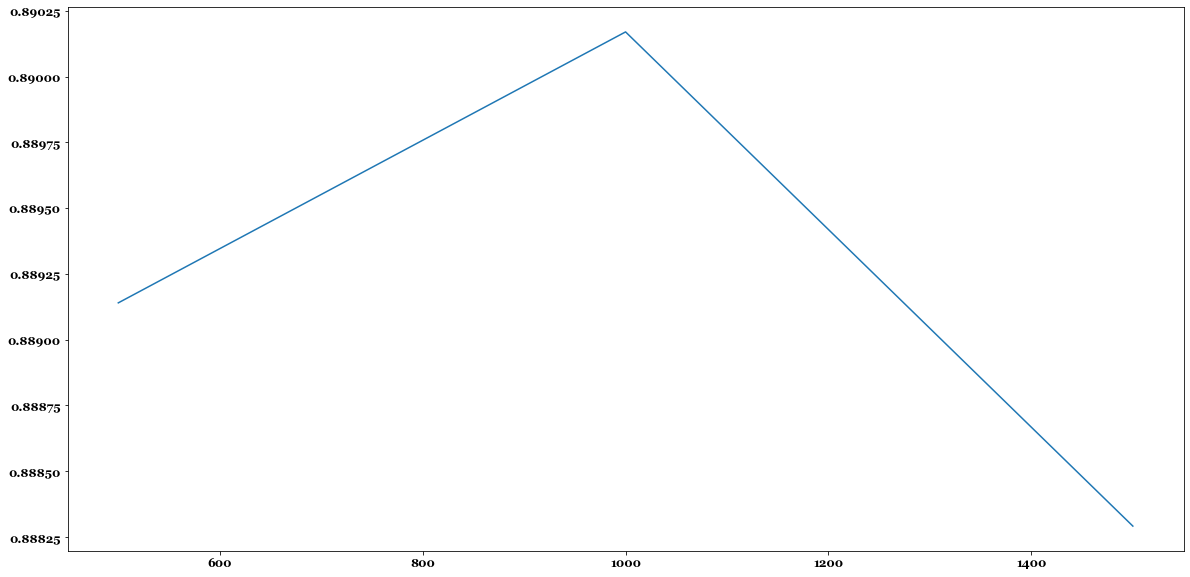

In [436]:
plt.plot(np.arange(500, 1600, 500), scores)

In [359]:
filled_nas.to_csv('data/final_columns.csv', index=False)

In [455]:
dp = {"org_name": "DREAM Project Foundation", "name_length": 51, "event_end": 1363928400, "venue_latitude": 42.9630578, "event_published": 1361978554.0, "user_type": 1, "channels": 11, "currency": "USD", "org_desc": "", "event_created": 1361291193, "event_start": 1363914000, "has_logo": 1, "email_domain": "dreamprojectfoundation.org", "user_created": 1361290985, "payee_name": "", "payout_type": "ACH", "venue_name": "Grand Rapids Brewing Co", "sale_duration2": 30, "venue_address": "1 Ionia Avenue Southwest", "approx_payout_date": 1364360400, "org_twitter": 13.0, "gts": 537.4, "listed": "y", "ticket_types": [{"event_id": 5558108, "cost": 50.0, "availability": 1, "quantity_total": 125, "quantity_sold": 10}], "org_facebook": 13.0, "num_order": 7, "user_age": 0, "body_length": 1474, "description": "<p><span style=\"font-size: medium; font-family: 'book antiqua', palatino;\">Come enjoy a night of music and beer tasting at the new Grand Rapids Brewery while we make an effort to create awareness and raise funds for Dream Project Foundation. The night will include music, Grand Rapids Brewery's finest beer to sample, heavy hors d'oeuvre's and silent auction of artwork directly from the young artists of Dream House.</span></p>\r\n<p>&nbsp;</p>\r\n<p>Who We Are:</p>\r\n<p>DREAM Project Foundation is a small American 501c3 registered non-profit organization, working to break the cycle of human trafficking through community development. As a small, grass roots organization, we focus primarily on prevention and protection which begins with shelter and continues with education, so those vulnerable are aware of the dangers and able to protect themselves.</p>\r\n<p>DREAM Project Foundation was officially founded in 2011 to support the DREAM House children's home based in Thailand on the border of Myanar (Burma). While helping children stay safe from the trafficing is the heart of our mission, we know that in order to end trafficking it must be a collaborative effort for all people and communities.&nbsp;</p>\r\n<p>We at DREAM Project Foundation are determined to fight against this atrocity, focusing on the factors that cause people to be vulnerable targets to traffickers, with most of our work based in SE Asia as it is a major international hub of human trafficking.</p>", "object_id": 5558108, "venue_longitude": -85.6706147, "venue_country": "US", "previous_payouts": [{"name": "", "created": "2013-04-19 03:25:42", "country": "US", "state": "", "amount": 500.0, "address": "", "zip_code": "", "event": 5558108, "uid": 52778636}], "sale_duration": 22.0, "num_payouts": 0, "name": "DREAM Project Foundation - Taste of a Better Future", "country": "US", "delivery_method": 0.0, "has_analytics": 0, "fb_published": 0, "venue_state": "MI", "has_header": np.nan, "show_map": 1}

In [378]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   org_name            1 non-null      object 
 1   name_length         1 non-null      int64  
 2   event_end           1 non-null      int64  
 3   venue_latitude      1 non-null      float64
 4   event_published     1 non-null      float64
 5   user_type           1 non-null      int64  
 6   channels            1 non-null      int64  
 7   currency            1 non-null      object 
 8   org_desc            1 non-null      object 
 9   event_created       1 non-null      int64  
 10  event_start         1 non-null      int64  
 11  has_logo            1 non-null      int64  
 12  email_domain        1 non-null      object 
 13  user_created        1 non-null      int64  
 14  payee_name          1 non-null      object 
 15  payout_type         1 non-null      object 
 16  venue_name  

In [420]:
dp.head()

,org_name,name_length,event_end,venue_latitude,event_published,user_type,channels,currency,org_desc,event_created,event_start,has_logo,email_domain,user_created,payee_name,payout_type,venue_name,sale_duration2,venue_address,approx_payout_date,org_twitter,gts,listed,ticket_types,org_facebook,num_order,user_age,body_length,description,object_id,venue_longitude,venue_country,previous_payouts,sale_duration,num_payouts,name,country,delivery_method,has_analytics,fb_published,venue_state,has_header,show_map
0,DREAM Project Foundation,51,1363928400,42.963058,1.361979e+09,1,11,USD,,1361291193,1363914000,1,dreamprojectfoundation.org,1361290985,,ACH,Grand Rapids Brewing Co,30,1 Ionia Avenue Southwest,1364360400,13.0,537.4,y,"{'event_id': 5558108, 'cost': 50.0, 'availability': 1, 'quantity_total': 125, 'quantity_sold': 10}",13.0,7,0,1474,"<p><span style=""font-size: medium; font-family: 'book antiqua', palatino;"">Come enjoy a night of music and beer tasting at the new Grand Rapids Brewery while we make an effort to create awareness and raise funds for Dream Project Foundation. The night will include music, Grand Rapids Brewery's finest beer to sample, heavy hors d'oeuvre's and silent auction of artwork directly from the young artists of Dream House.</span></p>\r\n<p>&nbsp;</p>\r\n<p>Who We Are:</p>\r\n<p>DREAM Project Foundation is a small American 501c3 registered non-profit organization, working to break the cycle of human...",5558108,-85.670615,US,"{'name': '', 'created': '2013-04-19 03:25:42', 'country': 'US', 'state': '', 'amount': 500.0, 'address': '', 'zip_code': '', 'event': 5558108, 'uid': 52778636}",22.0,0,DREAM Project Foundation - Taste of a Better Future,US,0.0,0,0,MI,NaN,1


In [442]:
dp.drop(['org_name', 'event_end', 'venue_latitude', 'event_published', 'currency', 'org_desc', 'event_created', 'event_start', 'user_created', 'payee_name', 'payout_type', 'venue_name', 'sale_duration2', 'venue_address', 'approx_payout_date', 'num_order', 'gts', 'listed', 'description', 'object_id', 'venue_longitude', 'sale_duration', 'name', 'country', 'venue_state'], axis=1, inplace=True)

In [445]:
no_time.columns

Index(['body_length', 'channels', 'fb_published', 'has_logo', 'name_length',
       'org_facebook', 'org_twitter', 'show_map', 'user_age', 'user_type',
       'Label', 'previous_payout0', 'has_header_0.0', 'has_header_1.0',
       'has_header_nan', 'yahoo', 'is_fr', 'is_org', 'delivery_method_0.0',
       'delivery_method_1.0', 'delivery_method_3.0', 'delivery_method_nan'],
      dtype='object')

In [443]:
dp.columns

Index(['name_length', 'user_type', 'channels', 'has_logo', 'email_domain',
       'org_twitter', 'ticket_types', 'org_facebook', 'num_order', 'user_age',
       'body_length', 'venue_country', 'previous_payouts', 'num_payouts',
       'delivery_method', 'has_analytics', 'fb_published', 'has_header',
       'show_map'],
      dtype='object')

In [452]:
order = dp.loc[:, ['body_length', 'channels', 'fb_published', 'has_logo', 'name_length', 'org_facebook', 'org_twitter', 'show_map', 'user_age', 'user_type']]

In [454]:
def input_pipeline(entry):
    df = pd.DataFrame(entry)
    df.drop(['org_name', 'event_end', 'venue_latitude', 'event_published', 'currency', 'org_desc', 'event_created', 'event_start', 
               'user_created', 'payee_name', 'payout_type', 'venue_name', 'sale_duration2', 'venue_address', 'approx_payout_date', 
               'num_order', 'gts', 'listed', 'description', 'object_id', 'venue_longitude', 'sale_duration', 'name', 'country', 'venue_state'], axis=1, inplace=True)
    return df

In [456]:
input_pipeline(dp)

,name_length,user_type,channels,has_logo,email_domain,org_twitter,ticket_types,org_facebook,user_age,body_length,venue_country,previous_payouts,num_payouts,delivery_method,has_analytics,fb_published,has_header,show_map
0,51,1,11,1,dreamprojectfoundation.org,13.0,"{'event_id': 5558108, 'cost': 50.0, 'availability': 1, 'quantity_total': 125, 'quantity_sold': 10}",13.0,0,1474,US,"{'name': '', 'created': '2013-04-19 03:25:42', 'country': 'US', 'state': '', 'amount': 500.0, 'address': '', 'zip_code': '', 'event': 5558108, 'uid': 52778636}",0,0.0,0,0,NaN,1


In [494]:
grantsdata = pd.read_csv('data/fraud_data.csv', index_col=0)

In [495]:
added_data = grantsdata.drop(['event_id', 'ticket_quant_sold'], axis=1)

In [496]:
ticket_data = pd.concat([no_time, added_data], axis=1)

In [522]:
neg_value_cols = ticket_data

In [532]:
neg_value_cols.loc[:, 'ticket_cost':'ticket_quant_total'] = neg_value_cols.loc[:, 'ticket_cost':'ticket_quant_total'].fillna()

,ticket_cost,ticket_availability,ticket_quant_total
0,208.333333,1.0,306.666667
1,35.000000,1.0,50.000000
2,93.510000,1.0,48.000000
3,13.666667,1.0,5000.000000
4,101.750000,1.0,33.000000
...,...,...,...
14332,45.000000,1.0,400.000000
14333,43.250000,1.0,407.000000
14334,42.000000,1.0,29.600000
14335,79.330000,1.0,50.000000


In [534]:
neg_value_cols['ticket_cost'].fillna(-99,inplace=True)
neg_value_cols['ticket_availability'].fillna(-99, inplace=True)
neg_value_cols['ticket_quant_total'].fillna(-99, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_length          14337 non-null  int64  
 1   channels             14337 non-null  int64  
 2   fb_published         14337 non-null  int64  
 3   has_logo             14337 non-null  int64  
 4   name_length          14337 non-null  int64  
 5   org_facebook         14337 non-null  float64
 6   org_twitter          14337 non-null  float64
 7   show_map             14337 non-null  int64  
 8   user_age             14337 non-null  int64  
 9   user_type            14337 non-null  int64  
 10  Label                14337 non-null  int64  
 11  previous_payout0     14337 non-null  int64  
 12  has_header_0.0       14337 non-null  uint8  
 13  has_header_1.0       14337 non-null  uint8  
 14  has_header_nan       14337 non-null  uint8  
 15  yahoo                14337 non-null 

In [582]:
neg_value_cols.to_csv(
'')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   body_length          14337 non-null  int64  
 1   channels             14337 non-null  int64  
 2   fb_published         14337 non-null  int64  
 3   has_logo             14337 non-null  int64  
 4   name_length          14337 non-null  int64  
 5   org_facebook         14337 non-null  float64
 6   org_twitter          14337 non-null  float64
 7   show_map             14337 non-null  int64  
 8   user_age             14337 non-null  int64  
 9   user_type            14337 non-null  int64  
 10  Label                14337 non-null  int64  
 11  previous_payout0     14337 non-null  int64  
 12  has_header_0.0       14337 non-null  uint8  
 13  has_header_1.0       14337 non-null  uint8  
 14  has_header_nan       14337 non-null  uint8  
 15  yahoo                14337 non-null 